# CS246 - Colab 3
## K-Means & PCA

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.4 MB 71 kB/s 
     |████████████████████████████████| 198 kB 37.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=b8eefa4ef83043f4df775bdb0cbff3db259f9dd6d2a00cb2b056286709ab76cf
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Rea

Now we import some of the libraries usually needed by our workload.





In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [4]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [5]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2021-09-27 07:21:58--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  39.4MB/s    in 0.3s    

2021-09-27 07:21:59 (39.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


### Data Preprocessing

In this Colab, rather than downloading a file from Google Drive, we will load a famous machine learning dataset, the [Breast Cancer Wisconsin dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), using the ```scikit-learn``` datasets loader.

In [6]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()

For convenience, given that the dataset is small, we first construct a Pandas dataframe, tune the schema, and then convert it into a Spark dataframe.

In [7]:
pd_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df = spark.createDataFrame(pd_df)

def set_df_columns_nullable(spark, df, column_list, nullable=False):
    for struct_field in df.schema:
        if struct_field.name in column_list:
            struct_field.nullable = nullable
    df_mod = spark.createDataFrame(df.rdd, df.schema)
    return df_mod

df = set_df_columns_nullable(spark, df, df.columns)
df = df.withColumn('features', array(df.columns))
vectors = df.rdd.map(lambda row: Vectors.dense(row.features))

df.printSchema()

root
 |-- mean radius: double (nullable = false)
 |-- mean texture: double (nullable = false)
 |-- mean perimeter: double (nullable = false)
 |-- mean area: double (nullable = false)
 |-- mean smoothness: double (nullable = false)
 |-- mean compactness: double (nullable = false)
 |-- mean concavity: double (nullable = false)
 |-- mean concave points: double (nullable = false)
 |-- mean symmetry: double (nullable = false)
 |-- mean fractal dimension: double (nullable = false)
 |-- radius error: double (nullable = false)
 |-- texture error: double (nullable = false)
 |-- perimeter error: double (nullable = false)
 |-- area error: double (nullable = false)
 |-- smoothness error: double (nullable = false)
 |-- compactness error: double (nullable = false)
 |-- concavity error: double (nullable = false)
 |-- concave points error: double (nullable = false)
 |-- symmetry error: double (nullable = false)
 |-- fractal dimension error: double (nullable = false)
 |-- worst radius: double (nullable

With the next cell, we build the two datastructures that we will be using throughout this Colab:


*   ```features```, a dataframe of Dense vectors, containing all the original features in the dataset;
*   ```labels```, a series of binary labels indicating if the corresponding set of features belongs to a subject with breast cancer, or not.



In [8]:
from pyspark.ml.linalg import Vectors
features = spark.createDataFrame(vectors.map(Row), ["features"])
labels = pd.Series(breast_cancer.target)

In [9]:
df.show()

+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+--------------------+
|mean radius|mean texture|mean perimeter|mean area|mean smoothness|mean compactness|mean concavity|mean concave points|mean symmetry|mean fractal dimension|radius error|texture error|perimeter error|area error|smoothness error|compactness error|concavity error|concave points error|symmetry error|fractal dimension error|worst radius|worst texture|worst perimeter|worst area|worst smoothness|worst compactness|worst concavity|worst concave points|worst symmetry|worst fractal dimension|      

### Your task

If you run successfully the Setup and Data Preprocessing stages, you are now ready to cluster the data with the [K-means](https://spark.apache.org/docs/latest/ml-clustering.html) algorithm included in MLlib (Spark's Machine Learning library).
Set the ```k``` parameter to **2**, fit the model, and the compute the [Silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) (i.e., a measure of quality of the obtained clustering).  

**IMPORTANT:** use the MLlib implementation of the Silhouette score (via ```ClusteringEvaluator```).

In [14]:
# YOUR CODE HERE
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

k = 2

# Trains a k-means model.
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(features)

In [16]:
# Make predictions
predictions = model.transform(features)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)

silhouette

0.8342904262826145

Text(0, 0.5, 'cost')

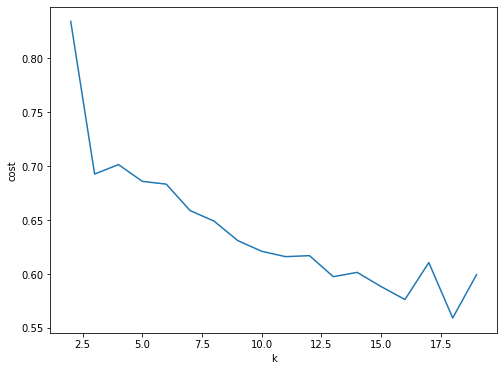

In [21]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(features)
    # Make predictions 
    predictions = model.transform(features)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    cost[k] = silhouette 

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

K=2 is the best choice

Take the predictions produced by K-means, and compare them with the ```labels``` variable (i.e., the ground truth from our dataset).  

Compute how many data points in the dataset have been clustered correctly (i.e., positive cases in one cluster, negative cases in the other).

*HINT*: you can use ```np.count_nonzero(series_a == series_b)``` to quickly compute the element-wise comparison of two series.

**IMPORTANT**: K-means is a clustering algorithm, so it will not output a label for each data point, but just a cluster identifier!  As such, label ```0``` does not necessarily match the cluster identifier ```0```.


In [22]:
# YOUR CODE HERE
predictions_df = predictions.toPandas()
predictions_df.head()

,features,prediction
0,"[17.99, 10.38, 122.8, 1001.0, 0.1184, 0.2776, ...",16
1,"[20.57, 17.77, 132.9, 1326.0, 0.08474, 0.07864...",2
2,"[19.69, 21.25, 130.0, 1203.0, 0.1096, 0.1599, ...",11
3,"[11.42, 20.38, 77.58, 386.1, 0.1425, 0.2839, 0...",10
4,"[20.29, 14.34, 135.1, 1297.0, 0.1003, 0.1328, ...",15


In [27]:
pred = pd.Series(np.where(predictions_df.prediction.values, 1, 0), predictions_df.index)
pred.head()

0    1
1    1
2    1
3    1
4    1
dtype: int64

In [28]:
np.count_nonzero(pred.values == labels.values)

269

Now perform dimensionality reduction on the ```features``` using the [PCA](https://spark.apache.org/docs/latest/ml-features.html#pca) statistical procedure, available as well in MLlib.

Set the ```k``` parameter to **2**, effectively reducing the dataset size of a **15X** factor.

In [46]:
# YOUR CODE HERE
# Import PCA
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

# Init model
pca = PCA(k=2, inputCol="features", outputCol="pca")

# Fitting data
model = pca.fit(features)

# Transform
result = model.transform(features).select("pca")
result.show(truncate=False)

+-----------------------------------------+
|pca                                      |
+-----------------------------------------+
|[-2260.0138862925405,-187.9603012226368] |
|[-2368.993755782054,121.58742425815508]  |
|[-2095.6652015478608,145.11398565870087] |
|[-692.6905100570508,38.576922592081765]  |
|[-2030.2124927427062,295.2979839927924]  |
|[-888.280053576076,26.079796157025726]   |
|[-1921.082212474845,58.807572473099206]  |
|[-1074.7813350047961,31.771227808469668] |
|[-908.5784781618829,63.83075279044624]   |
|[-861.5784494075679,40.57073549705321]   |
|[-1404.559130649947,88.23218257736237]   |
|[-1524.2324408687816,-3.2630573167779793]|
|[-1734.385647746415,273.1626781511459]   |
|[-1162.9140032230355,217.63481808344613] |
|[-903.4301030498832,135.61517666084782]  |
|[-1155.8759954206848,76.80889383742165]  |
|[-1335.7294321308068,-2.4684005450356024]|
|[-1547.2640922523087,3.805675972574325]  |
|[-2714.9647651812156,-164.37610864258804]|
|[-908.2502671870876,118.2164200

Now run K-means with the same parameters as above, but on the ```pcaFeatures``` produced by the PCA reduction you just executed.

Compute the Silhouette score, as well as the number of data points that have been clustered correctly.

In [47]:
# YOUR CODE HERE
kmeans = KMeans(featuresCol='pca').setK(2).setSeed(1)
model = kmeans.fit(result)

Text(0, 0.5, 'cost')

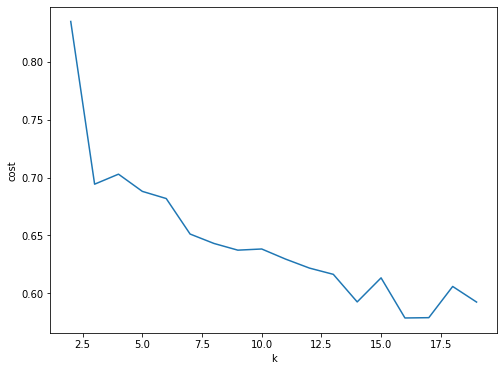

In [50]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans(featuresCol='pca').setK(k).setSeed(1)
    model = kmeans.fit(result)
    # Make predictions 
    predictions = model.transform(result)
    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator(featuresCol='pca')
    silhouette = evaluator.evaluate(predictions)
    cost[k] = silhouette 

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [35]:
# YOUR CODE HERE
pca_predictions = model.transform(result)
pca_evaluator = ClusteringEvaluator(featuresCol='pca')

pca_silhouette = pca_evaluator.evaluate(pca_predictions)

print("Silhouette after PCS: {}".format(pca_silhouette))

Silhouette after PCS: 0.8348610363444836


In [38]:
pca_predictions_df = pca_predictions.toPandas()
pca_predictions_df.head()

,pca,prediction
0,"[-2260.0138862925405, -187.9603012226368]",1
1,"[-2368.993755782054, 121.58742425815508]",1
2,"[-2095.6652015478608, 145.11398565870087]",1
3,"[-692.6905100570508, 38.576922592081765]",0
4,"[-2030.2124927427062, 295.2979839927924]",1


In [42]:
pred = pd.Series(np.where(predictions_df.prediction.values == 1, 1, 0), predictions_df.index)
pred.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [43]:
np.count_nonzero(pred.values == labels.values)

290

Once you obtained the desired results, **head over to Gradescope and submit your solution for this Colab**!